In [0]:
# https://www.datacamp.com/courses/winning-a-kaggle-competition-in-python

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from math import sqrt
import itertools
import xgboost as xgb

In [0]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, log_loss
from sklearn.model_selection import KFold, StratifiedKFold, TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression

Note:

The csv documents were renamed, please change the text accordingly for your own usage.

chapter | original | changed to
--- | --- | ---
1|train.csv|demand_forecasting_train_1_month.csv
1|test.csv |demand_forecasting_test.csv 
2|train|taxi_train_chapter_4 
2|test|taxi_test_chapter_4
3|train|house_prices_train
3|test|house_prices_test
4|train|taxi_train_nona
4|test|taxi_test_nona

In [0]:
# print all 45000 rows of dataframe
pd.set_option('display.max_rows', 45000)

**Course Description**

Kaggle is the most famous platform for Data Science competitions. Taking part in such competitions allows you to work with real-world datasets, explore various machine learning problems, compete with other participants and, finally, get invaluable hands-on experience. In this course, you will learn how to approach and structure any Data Science competition. You will be able to select the correct local validation scheme and to avoid overfitting. Moreover, you will master advanced feature engineering together with model ensembling approaches. All these techniques will be practiced on Kaggle competitions datasets.

## 1. Kaggle competitions process

In this first chapter, you will get exposure to the Kaggle competition process. You will train a model and prepare a csv file ready for submission. You will learn the difference between Public and Private test splits, and how to prevent overfitting.

#### Explore train data

You will work with another Kaggle competition called "Store Item Demand Forecasting Challenge". In this competition, you are given 5 years of store-item sales data, and asked to predict 3 months of sales for 50 different items in 10 different stores.

In [0]:
# Import pandas
import pandas as pd

# Read train data
train = pd.read_csv('demand_forecasting_train_1_month.csv')

# Look at the shape of the data
print('Train shape:', train.shape)

# Look at the head of the data
print(train.head())  # (15500, 5)

Train shape: (15500, 5)
       id        date  store  item  sales
0  100000  2017-12-01      1     1     19
1  100001  2017-12-02      1     1     16
2  100002  2017-12-03      1     1     31
3  100003  2017-12-04      1     1      7
4  100004  2017-12-05      1     1     20


#### Explore test data

Having looked at the train data, let's explore the test data in the "Store Item Demand Forecasting Challenge". Remember, that the test dataset generally contains one column less than the train one.

This column, together with the output format, is presented in the sample submission file. Before making any progress in the competition, you should get familiar with the expected output.

In [0]:
import pandas as pd

# Read test data
test = pd.read_csv('demand_forecasting_test.csv')

# Print train and test columns
print('Train columns:', train.columns.tolist())
print('Test columns:', test.columns.tolist())

Train columns: ['id', 'date', 'store', 'item', 'sales']
Test columns: ['id', 'date', 'store', 'item']


In [0]:
# Read sample submission
# sample_submission = pd.read_csv('sample_submission.csv') # datacamp solutions
sample_submission = pd.read_csv('sample_submission.csv', index_col = a)

# Look at the head of sample submission
print(sample_submission.head())

In [0]:
# sanity check
print("shape of submission file: ", sample_submission.shape)
# sample_submission.shape = (45000, 2)
sample_submission.head(5)

#### Determine a problem type

Before building a model, you should determine the problem type you are addressing. The goal of this exercise is to **look at the distribution of the target variable**, and select the correct problem type you will be building a model for.


#### Train a simple model

As you determined, you are dealing with a regression problem. So, now you're ready to build a model for a subsequent submission. But now, instead of building the simplest Linear Regression model as in the slides, let's build an out-of-box Random Forest model.

In [0]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

# Read train data
train = pd.read_csv('demand_forecasting_train_1_month.csv')

# Create Random Forest object
rf = RandomForestRegressor()

# Train a model
rf.fit(X=train[['store', 'item']], y=train['sales'])

In [0]:
# Read test and sample_submission data
test = pd.read_csv('demand_forecasting_test.csv')
# sample_sub = pd.read_csv('sample_submission.csv')
sample_sub = pd.read_csv('sample_submission.csv', index_col=0)

# Show head of sample_submission
print(sample_sub.head())

Empty DataFrame
Columns: []
Index: [0          0     52, 1          1     52, 2          2     52, 3          3     52, 4          4     52]


In [0]:
sample_sub.head(5)

""
id sales
0 0 52
1 1 52
2 2 52
3 3 52
4 4 52


#### Prepare a submission

You've already built a model on the training data from the Kaggle Store Item Demand Forecasting Challenge. Now, it's time to make predictions on the test data and create a submission file in the specified format.

Your goal is to read the test data, make predictions, and save these in the format specified in the "sample_submission.csv" file. The rf object you created in the previous exercise is available in your workspace.

In [0]:
# Read test and sample submission data
test = pd.read_csv('demand_forecasting_test.csv')
sample_sub = pd.read_csv('sample_submission.csv', index_col=0)

# Show head of sample_submission
print(sample_sub.head())

Empty DataFrame
Columns: []
Index: [0          0     52, 1          1     52, 2          2     52, 3          3     52, 4          4     52]


In [0]:
# Get predictions for the test set
test['sales'] = rf.predict(test[['store', 'item']])

# Write test predictions in the sample_submission format
test[['id', 'sales']].to_csv('kaggle_submission.csv', index=False)

In [0]:
# sanity check
kag_sub = pd.read_csv('kaggle_submission.csv')
kag_sub.head(5)

,id,sales
0,0,17.496249
1,1,17.496249
2,2,17.496249
3,3,17.496249
4,4,17.496249


#### Train XGBoost models

Every Machine Learning method could potentially overfit. You will see it on this example with XGBoost.

Firstly, let's train multiple XGBoost models with different sets of hyperparameters using XGBoost's learning API. 

1. Set the maximum depth to 2, to train the first model.

In [0]:
import xgboost as xgb

# Create DMatrix on train data
dtrain = xgb.DMatrix(data=train[['store', 'item']],
                     label=train['sales'])

# Define xgboost parameters
params = {'objective': 'reg:linear',
          'max_depth': 2,
          'silent': 1}

# Train xgboost model
xg_depth_2 = xgb.train(params=params, dtrain=dtrain)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


2. Now, set the maximum depth to 8.

In [0]:
import xgboost as xgb

# Create DMatrix on train data
dtrain = xgb.DMatrix(data=train[['store', 'item']],
                     label=train['sales'])

# Define xgboost parameters
params = {'objective': 'reg:linear',
          'max_depth': 8,
          'silent': 1}

# Train xgboost model
xg_depth_8 = xgb.train(params=params, dtrain=dtrain)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


3. Finally, set the maximum depth to 15. 

In [0]:
import xgboost as xgb

# Create DMatrix on train data
dtrain = xgb.DMatrix(data=train[['store', 'item']],
                     label=train['sales'])

# Define xgboost parameters
params = {'objective': 'reg:linear',
          'max_depth': 15,
          'silent': 1}

# Train xgboost model
xg_depth_15 = xgb.train(params=params, dtrain=dtrain)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


#### Explore overfitting XGBoost

Having trained 3 XGBoost models with different maximum depths, you will now evaluate their quality. For this purpose, you will measure the quality of each model on both the train data and the test data. 

The goal of this exercise is to determine whether any of the models trained is overfitting. To measure the quality of the models you will use Mean Squared Error (MSE). It's available in sklearn.metrics as mean_squared_error() function that takes two arguments: true values and predicted values.

In [0]:
from sklearn.metrics import mean_squared_error

dtrain = xgb.DMatrix(data=train[['store', 'item']])
dtest = xgb.DMatrix(data=test[['store', 'item']])

# For each of 3 trained models
for model in [xg_depth_2, xg_depth_8, xg_depth_15]:
    # Make predictions
    train_pred = model.predict(dtrain)     
    test_pred = model.predict(dtest)          
    
    # Calculate metrics
    mse_train = mean_squared_error(train['sales'], train_pred)                  
    mse_test = mean_squared_error(test['sales'], test_pred)
    print('MSE Train: {:.3f}. MSE Test: {:.3f}'.format(mse_train, mse_test))

MSE Train: 331.064. MSE Test: 249.174
MSE Train: 112.057. MSE Test: 30.518
MSE Train: 84.952. MSE Test: 3.680


## 2. Dive into the Competition

Now that you know the basics of Kaggle competitions, you will learn how to study the specific problem at hand. You will practice EDA and get to establish correct local validation strategies. You will also learn about data leakage.

**Define a competition metric**

Competition metric is used by Kaggle to evaluate your submissions. Moreover, you also need to measure the performance of different models on a local validation set.

For now, your goal is to manually develop a couple of competition metrics in case if they are not available in sklearn.metrics.

In particular, you will define:

Mean Squared Error (MSE) for the regression problem:

$$MSE=\frac{1}{N} \sum_{i=1}^\{N} (y_{i}−ŷ _{i})^{2}$$

Logarithmic Loss (LogLoss) for the binary classification problem:

$$LogLoss=−\frac{1}{N} \sum_{i=1}^\{N}(y_{i}logp_{i}+(1−y_{i})log(1−p_{i}))$$

[formula link](https://campus.datacamp.com/courses/winning-a-kaggle-competition-in-python/dive-into-the-competition?ex=3)

In [0]:
y_regression_true = np.array([0.69646919, 0.28613933, 0.22685145, 0.55131477, 0.71946897,
       0.42310646, 0.9807642 , 0.68482974, 0.4809319 , 0.39211752,
       0.34317802, 0.72904971, 0.43857224, 0.0596779 , 0.39804426,
       0.73799541, 0.18249173, 0.17545176, 0.53155137, 0.53182759,
       0.63440096, 0.84943179, 0.72445532, 0.61102351, 0.72244338,
       0.32295891, 0.36178866, 0.22826323, 0.29371405, 0.63097612,
       0.09210494, 0.43370117, 0.43086276, 0.4936851 , 0.42583029,
       0.31226122, 0.42635131, 0.89338916, 0.94416002, 0.50183668,
       0.62395295, 0.1156184 , 0.31728548, 0.41482621, 0.86630916,
       0.25045537, 0.48303426, 0.98555979, 0.51948512, 0.61289453,
       0.12062867, 0.8263408 , 0.60306013, 0.54506801, 0.34276383,
       0.30412079, 0.41702221, 0.68130077, 0.87545684, 0.51042234,
       0.66931378, 0.58593655, 0.6249035 , 0.67468905, 0.84234244,
       0.08319499, 0.76368284, 0.24366637, 0.19422296, 0.57245696,
       0.09571252, 0.88532683, 0.62724897, 0.72341636, 0.01612921,
       0.59443188, 0.55678519, 0.15895964, 0.15307052, 0.69552953,
       0.31876643, 0.6919703 , 0.55438325, 0.38895057, 0.92513249,
       0.84167   , 0.35739757, 0.04359146, 0.30476807, 0.39818568,
       0.70495883, 0.99535848, 0.35591487, 0.76254781, 0.59317692,
       0.6917018 , 0.15112745, 0.39887629, 0.2408559 , 0.34345601])


In [0]:
y_regression_pred = np.array([0.51312815, 0.66662455, 0.10590849, 0.13089495, 0.32198061,
       0.66156434, 0.84650623, 0.55325734, 0.85445249, 0.38483781,
       0.3167879 , 0.35426468, 0.17108183, 0.82911263, 0.33867085,
       0.55237008, 0.57855147, 0.52153306, 0.00268806, 0.98834542,
       0.90534158, 0.20763586, 0.29248941, 0.52001015, 0.90191137,
       0.98363088, 0.25754206, 0.56435904, 0.80696868, 0.39437005,
       0.73107304, 0.16106901, 0.60069857, 0.86586446, 0.98352161,
       0.07936579, 0.42834727, 0.20454286, 0.45063649, 0.54776357,
       0.09332671, 0.29686078, 0.92758424, 0.56900373, 0.457412  ,
       0.75352599, 0.74186215, 0.04857903, 0.7086974 , 0.83924335,
       0.16593788, 0.78099794, 0.28653662, 0.30646975, 0.66526147,
       0.11139217, 0.66487245, 0.88785679, 0.69631127, 0.44032788,
       0.43821438, 0.7650961 , 0.565642  , 0.08490416, 0.58267109,
       0.8148437 , 0.33706638, 0.92757658, 0.750717  , 0.57406383,
       0.75164399, 0.07914896, 0.85938908, 0.82150411, 0.90987166,
       0.1286312 , 0.08178009, 0.13841557, 0.39937871, 0.42430686,
       0.56221838, 0.12224355, 0.2013995 , 0.81164435, 0.46798757,
       0.80793821, 0.00742638, 0.55159273, 0.93193215, 0.58217546,
       0.20609573, 0.71775756, 0.37898585, 0.66838395, 0.02931972,
       0.63590036, 0.03219793, 0.74478066, 0.472913  , 0.12175436])

In [0]:
import numpy as np

# Import MSE from sklearn
from sklearn.metrics import mean_squared_error

# Define your own MSE function
def own_mse(y_true, y_pred):
  	# Find squared differences
    squares = np.power(y_true - y_pred, 2)
    # Find mean over all observations
    err = np.mean(squares)   
    return err

print('Sklearn MSE: {:.5f}'.format(mean_squared_error(y_regression_true, y_regression_pred)))
print('Your MSE: {:.5f}'.format(own_mse(y_regression_true, y_regression_pred)))

Sklearn MSE: 0.15418
Your MSE: 0.15418


In [0]:
y_classification_true = np.array([1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0,
       1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0])

In [0]:
y_classification_pred = np.array([0.2082483 , 0.4433677 , 0.71560128, 0.41051979, 0.19100696,
       0.96749431, 0.65075037, 0.86545985, 0.02524236, 0.26690581,
       0.5020711 , 0.06744864, 0.99303326, 0.2364624 , 0.37429218,
       0.21401191, 0.10544587, 0.23247979, 0.30061014, 0.63444227,
       0.28123478, 0.36227676, 0.00594284, 0.36571913, 0.53388598,
       0.16201584, 0.59743311, 0.29315247, 0.63205049, 0.02619661,
       0.88759346, 0.01611863, 0.12695803, 0.77716246, 0.04589523,
       0.71099869, 0.97104614, 0.87168293, 0.71016165, 0.95850974,
       0.42981334, 0.87287891, 0.35595767, 0.92976365, 0.14877766,
       0.94002901, 0.8327162 , 0.84605484, 0.12392301, 0.5964869 ,
       0.01639248, 0.72118437, 0.00773751, 0.08482228, 0.22549841,
       0.87512453, 0.36357632, 0.53995994, 0.56810321, 0.22546336,
       0.57214677, 0.6609518 , 0.29824539, 0.41862686, 0.45308892,
       0.93235066, 0.58749375, 0.94825237, 0.55603475, 0.50056142,
       0.00353221, 0.48088904, 0.927455  , 0.19836569, 0.05209113,
       0.40677889, 0.37239648, 0.85715306, 0.02661112, 0.92014923,
       0.680903  , 0.90422599, 0.60752907, 0.81195331, 0.33554387,
       0.34956623, 0.38987423, 0.75479708, 0.36929117, 0.24221981,
       0.93766836, 0.90801108, 0.34879732, 0.63463807, 0.27384221,
       0.20611513, 0.33633953, 0.32709989, 0.8822761 , 0.82230381])

In [0]:
import numpy as np

# Import log_loss from sklearn
from sklearn.metrics import log_loss

# Define your own LogLoss function
def own_logloss(y_true, prob_pred):
  	# Find loss for each observation
    terms = y_true * np.log(prob_pred) + (1 - y_true) * np.log(1 - prob_pred)
    # Find mean over all observations
    err = np.mean(terms)   
    return -err

print('Sklearn LogLoss: {:.5f}'.format(log_loss(y_classification_true, y_classification_pred)))
print('Your LogLoss: {:.5f}'.format(own_logloss(y_classification_true, y_classification_pred)))

Sklearn LogLoss: 1.10801
Your LogLoss: 1.10801


#### EDA statistics

As mentioned in the slides, you'll work with New York City taxi fare prediction data. You'll start with finding some basic statistics about the data. Then you'll move forward to plot some dependencies and generate hypotheses on them.

In [0]:
# load dataset

train = pd.read_csv("taxi_train_chapter_4.csv")
print("train dimension: ", train.shape)
train.head(5)

train dimension:  (20000, 8)


,id,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,1,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,3,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,4,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [0]:
# load dataset

test = pd.read_csv("taxi_test_chapter_4.csv")
print("test dimension: ", test.shape)
test.head(5)

test dimension:  (9914, 7)


,id,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,0,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1
1,1,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1
2,2,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1
3,3,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1
4,4,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1


In [0]:
# Shapes of train and test data
print('Train shape:', train.shape)
print('Test shape:', test.shape)

# Train head
print(train.head())

Train shape: (20000, 8)
Test shape: (9914, 7)
   id  fare_amount  ... dropoff_latitude  passenger_count
0   0          4.5  ...        40.712278                1
1   1         16.9  ...        40.782004                1
2   2          5.7  ...        40.750562                2
3   3          7.7  ...        40.758092                1
4   4          5.3  ...        40.783762                1

[5 rows x 8 columns]


In [0]:
# Shapes of train and test data
print('Train shape:', train.shape)
print('Test shape:', test.shape)

# Train head
print(train.head())

# Describe the target variable
print(train.fare_amount.describe())

# Train distribution of passengers within rides
print(train.passenger_count.value_counts())

Train shape: (20000, 8)
Test shape: (9914, 7)
   id  fare_amount  ... dropoff_latitude  passenger_count
0   0          4.5  ...        40.712278                1
1   1         16.9  ...        40.782004                1
2   2          5.7  ...        40.750562                2
3   3          7.7  ...        40.758092                1
4   4          5.3  ...        40.783762                1

[5 rows x 8 columns]
count    20000.000000
mean        11.303321
std          9.541637
min         -3.000000
25%          6.000000
50%          8.500000
75%         12.500000
max        180.000000
Name: fare_amount, dtype: float64
1    13999
2     2912
5     1327
3      860
4      420
6      407
0       75
Name: passenger_count, dtype: int64


#### EDA plots I

After generating a couple of basic statistics, it's time to come up with and validate some ideas about the data dependencies. Again, the train DataFrame from the taxi competition is already available in your workspace.

To begin with, let's make a scatterplot plotting the relationship between the fare amount and the distance of the ride. Intuitively, the longer the ride, the higher its price.

In [0]:
# written by instructor

def haversine_distance(train):
    
    data = [train]
    lat1, long1, lat2, long2 = 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'
    
    for i in data:
        R = 6371  #radius of earth in kilometers
        #R = 3959 #radius of earth in miles
        phi1 = np.radians(i[lat1])
        phi2 = np.radians(i[lat2])
    
        delta_phi = np.radians(i[lat2]-i[lat1])
        delta_lambda = np.radians(i[long2]-i[long1])
    
        #a = sin²((φB - φA)/2) + cos φA . cos φB . sin²((λB - λA)/2)
        a = np.sin(delta_phi / 2.0) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2.0) ** 2
    
        #c = 2 * atan2( √a, √(1−a) )
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    
        #d = R*c
        d = (R * c) #in kilometers
        
    return d

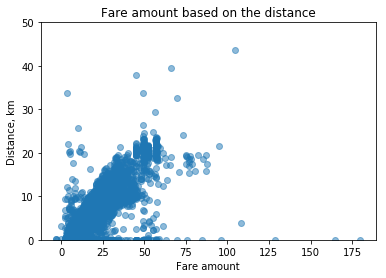

In [0]:
# Calculate the ride distance
train['distance_km'] = haversine_distance(train)

# Draw a scatterplot
plt.scatter(train.fare_amount, train.distance_km, alpha=0.5)
plt.xlabel('Fare amount')
plt.ylabel('Distance, km')
plt.title('Fare amount based on the distance')

# Limit on the distance
plt.ylim(0, 50)
plt.show()

#### EDA plots II

Another idea that comes to mind is that the price of a ride could change during the day.

Your goal is to plot the median fare amount for each hour of the day as a simple line plot. The hour feature is calculated for you. Don't worry if you do not know how to work with the date features. We will explore them in the chapter on Feature Engineering.

In [0]:
# Create hour feature
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
train['hour'] = train.pickup_datetime.dt.hour

# Find median fare_amount for each hour
hour_price = train.groupby('hour', as_index=False)['fare_amount'].median()

In [0]:
train.head(5)

,id,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_km,hour
0,0,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,1.030764,17
1,1,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,8.450134,16
2,2,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,1.389525,0
3,3,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,2.799270,4
4,4,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,1.999157,7


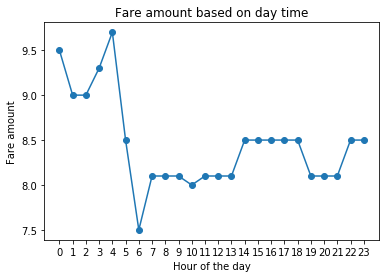

In [0]:
# Plot the line plot
plt.plot(hour_price.hour, hour_price.fare_amount, marker='o')
plt.xlabel('Hour of the day')
plt.ylabel('Fare amount')
plt.title('Fare amount based on day time')
plt.xticks(range(24))
plt.show()

#### K-fold cross-validation

The data you'll be working with is from the "Two sigma connect: rental listing inquiries" Kaggle competition. The competition problem is a multi-class classification of the rental listings into 3 classes: low interest, medium interest and high interest. For faster performance, you will work with a subsample consisting of 1,000 observations.

In [0]:
# load sub-sampled data
train = pd.read_csv("rental_subsample.csv", index_col=0)
train.head(5)

,id,bathrooms,bedrooms,building_id,latitude,longitude,manager_id,price,interest_level
,,,,,,,,,
0,10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,40.7145,-73.9425,5ba989232d0489da1b5f2c45f6688adc,3000,medium
1,10000,1.0,2,c5c8a357cba207596b04d1afd1e4f130,40.7947,-73.9667,7533621a882f71e25173b27e3139d83d,5465,low
2,100004,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,40.7388,-74.0018,d9039c43983f6e564b1482b273bd7b01,2850,high
3,100007,1.0,1,28d9ad350afeaab8027513a3e52ac8d5,40.7539,-73.9677,1067e078446a7897d2da493d2f741316,3275,low
4,100013,1.0,4,0,40.8241,-73.9493,98e13ad4b495b9613cef886d79a6291f,3350,low


In [0]:
# Import KFold
from sklearn.model_selection import KFold

# Create a KFold object
kf = KFold(n_splits=3, shuffle=True, random_state=123)

# Loop through each split
fold = 0
for train_index, test_index in kf.split(train):
    # Obtain training and testing folds
    cv_train, cv_test = train.iloc[train_index], train.iloc[test_index]
    print('Fold: {}'.format(fold))
    print('CV train shape: {}'.format(cv_train.shape))
    print('Medium interest listings in CV train: {}\n'.format(sum(cv_train.interest_level == 'medium')))
    fold += 1

Fold: 0
CV train shape: (666, 9)
Medium interest listings in CV train: 0

Fold: 1
CV train shape: (667, 9)
Medium interest listings in CV train: 0

Fold: 2
CV train shape: (667, 9)
Medium interest listings in CV train: 0



**Observation:**

So, we see that the number of observations in each fold is almost uniform. It means that we've just splitted the train data into 3 equal folds. However, if we look at the number of medium-interest listings, it's varying from 162 to 175 from one fold to another. To make them uniform among the folds, let's use Stratified K-fold!

#### Stratified K-fold

As you've just noticed, you have a pretty different target variable distribution among the folds due to the random splits. It's not crucial for this particular competition, but could be an issue for the classification competitions with the highly imbalanced target variable.

To overcome this, let's implement the stratified K-fold strategy with the stratification on the target variable.

In [0]:
# Import StratifiedKFold
from sklearn.model_selection import StratifiedKFold

# Create a StratifiedKFold object
str_kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=123)

# Loop through each split
fold = 0
for train_index, test_index in str_kf.split(train, train['interest_level']):
    # Obtain training and testing folds
    cv_train, cv_test = train.iloc[train_index], train.iloc[test_index]
    print('Fold: {}'.format(fold))
    print('CV train shape: {}'.format(cv_train.shape))
    print('Medium interest listings in CV train: {}\n'.format(sum(cv_train.interest_level == 'medium')))
    fold += 1

Fold: 0
CV train shape: (666, 9)
Medium interest listings in CV train: 0

Fold: 1
CV train shape: (666, 9)
Medium interest listings in CV train: 0

Fold: 2
CV train shape: (668, 9)
Medium interest listings in CV train: 0



#### Time K-fold

Remember the "Store Item Demand Forecasting Challenge" where you are given store-item sales data, and have to predict future sales?

It's a competition with time series data. So, time K-fold cross-validation should be applied. Your goal is to create this cross-validation strategy and make sure that it works as expected.

In [0]:
train = pd.read_csv("demand_forecasting_train_1_month.csv")
print("train data dimension: ", train.shape) # (15500, 5)
train.head(3)

train data dimension:  (15500, 5)


,id,date,store,item,sales
0,100000,2017-12-01,1,1,19
1,100001,2017-12-02,1,1,16
2,100002,2017-12-03,1,1,31


In [0]:
# Create TimeSeriesSplit object
time_kfold = TimeSeriesSplit(n_splits=3)

# Sort train data by date
train = train.sort_values('date')

# Iterate through each split
fold = 0
for train_index, test_index in time_kfold.split(train):
    cv_train, cv_test = train.iloc[train_index], train.iloc[test_index]
    
    print('Fold :', fold)
    print('Train date range: from {} to {}'.format(cv_train.date.min(), cv_train.date.max()))
    print('Test date range: from {} to {}\n'.format(cv_test.date.min(), cv_test.date.max()))
    fold += 1

Fold : 0
Train date range: from 2017-12-01 to 2017-12-08
Test date range: from 2017-12-08 to 2017-12-16

Fold : 1
Train date range: from 2017-12-01 to 2017-12-16
Test date range: from 2017-12-16 to 2017-12-24

Fold : 2
Train date range: from 2017-12-01 to 2017-12-24
Test date range: from 2017-12-24 to 2017-12-31



#### Overall validation score

Now it's time to get the actual model performance using cross-validation! How does our store item demand prediction model perform?

Your task is to take the Mean Squared Error (MSE) for each fold separately, and then combine these results into a single number.

In [0]:
def get_fold_mse(train, kf):
    mse_scores = []
    
    for train_index, test_index in kf.split(train):
        fold_train, fold_test = train.loc[train_index], train.loc[test_index]

        # Fit the data and make predictions
        # Create a Random Forest object
        rf = RandomForestRegressor(n_estimators=10, random_state=123)

        # Train a model
        rf.fit(X=fold_train[['store', 'item']], y=fold_train['sales'])

        # Get predictions for the test set
        pred = rf.predict(fold_test[['store', 'item']])
    
        fold_score = round(mean_squared_error(fold_test['sales'], pred), 5)
        mse_scores.append(fold_score)
        
    return mse_scores

In [0]:
def get_fold_mse(train, kf):
    mse_scores = []
    
    for train_index, test_index in kf.split(train):
        fold_train, fold_test = train.loc[train_index], train.loc[test_index]

        # Fit the data and make predictions
        # Create a Random Forest object
        rf = RandomForestRegressor(n_estimators=10, random_state=123)

        # Train a model
        rf.fit(X=fold_train[['store', 'item']], y=fold_train['sales'])

        # Get predictions for the test set
        pred = rf.predict(fold_test[['store', 'item']])
    
        fold_score = round(mean_squared_error(fold_test['sales'], pred), 5)
        mse_scores.append(fold_score)
        
    return mse_scores

In [0]:
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

# Sort train data by date
train = train.sort_values('date')

# Initialize 3-fold time cross-validation
kf = TimeSeriesSplit(n_splits=3)

# Get MSE scores for each cross-validation split
mse_scores = get_fold_mse(train, kf)

print('Mean validation MSE: {:.5f}'.format(np.mean(mse_scores)))

Mean validation MSE: 955.49186


In [0]:
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

# Sort train data by date
train = train.sort_values('date')

# Initialize 3-fold time cross-validation
kf = TimeSeriesSplit(n_splits=3)

# Get MSE scores for each cross-validation split
mse_scores = get_fold_mse(train, kf)

print('Mean validation MSE: {:.5f}'.format(np.mean(mse_scores)))
print('MSE by fold: {}'.format(mse_scores))

Mean validation MSE: 955.49186
MSE by fold: [890.30336, 961.65797, 1014.51424]


In [0]:
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

# Sort train data by date
train = train.sort_values('date')

# Initialize 3-fold time cross-validation
kf = TimeSeriesSplit(n_splits=3)

# Get MSE scores for each cross-validation split
mse_scores = get_fold_mse(train, kf)

print('Mean validation MSE: {:.5f}'.format(np.mean(mse_scores)))
print('MSE by fold: {}'.format(mse_scores))
print('Overall validation MSE: {:.5f}'.format(np.mean(mse_scores) + np.std(mse_scores)))

Mean validation MSE: 955.49186
MSE by fold: [890.30336, 961.65797, 1014.51424]
Overall validation MSE: 1006.38784


## 3. Feature Engineering

You will now get exposure to different types of features. You will modify existing features and create new ones. Also, you will treat the missing data accordingly.

In [0]:
train = pd.read_csv("house_prices_train.csv")
print("Train data dimension: ", train.shape) # (1460, 17)
train.head(5)

Train data dimension:  (1460, 17)


,Id,LotArea,OverallQual,YearBuilt,RoofStyle,TotalBsmtSF,CentralAir,1stFlrSF,2ndFlrSF,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,GarageCars,GarageArea,SalePrice
0,1,8450,7,2003,Gable,856,Y,856,854,2,1,3,1,8,2,548,208500
1,2,9600,6,1976,Gable,1262,Y,1262,0,2,0,3,1,6,2,460,181500
2,3,11250,7,2001,Gable,920,Y,920,866,2,1,3,1,6,2,608,223500
3,4,9550,7,1915,Gable,756,Y,961,756,1,0,3,1,7,3,642,140000
4,5,14260,8,2000,Gable,1145,Y,1145,1053,2,1,4,1,9,3,836,250000


In [0]:
test = pd.read_csv("house_prices_test.csv")
print("Test data dimension: ", test.shape)
test.head(5)

Test data dimension:  (1459, 16)


,Id,LotArea,OverallQual,YearBuilt,RoofStyle,TotalBsmtSF,CentralAir,1stFlrSF,2ndFlrSF,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,GarageCars,GarageArea
0,1461,11622,5,1961,Gable,882.0,Y,896,0,1,0,2,1,5,1.0,730.0
1,1462,14267,6,1958,Hip,1329.0,Y,1329,0,1,1,3,1,6,1.0,312.0
2,1463,13830,5,1997,Gable,928.0,Y,928,701,2,1,3,1,6,2.0,482.0
3,1464,9978,6,1998,Gable,926.0,Y,926,678,2,1,3,1,7,2.0,470.0
4,1465,5005,8,1992,Gable,1280.0,Y,1280,0,2,0,2,1,5,2.0,506.0


#### Arithmetical features

To practice creating new features, you will be working with a subsample from the Kaggle competition called "House Prices: Advanced Regression Techniques". The goal of this competition is to predict the price of the house based on its properties. It's a regression problem with Root Mean Squared Error as an evaluation metric.

Your goal is to create new features and determine whether they improve your validation score. To get the validation score from 5-fold cross-validation, you're given the get_kfold_rmse() function. 

In [0]:
def get_kfold_rmse(train):
    mse_scores = []

    for train_index, test_index in kf.split(train):
        train = train.fillna(0)
        feats = [x for x in train.columns if x not in ['Id', 'SalePrice', 'RoofStyle', 'CentralAir']]
        
        fold_train, fold_test = train.loc[train_index], train.loc[test_index]

        # Fit the data and make predictions
        # Create a Random Forest object
        rf = RandomForestRegressor(n_estimators=10, min_samples_split=10, random_state=123)

        # Train a model
        rf.fit(X=fold_train[feats], y=fold_train['SalePrice'])

        # Get predictions for the test set
        pred = rf.predict(fold_test[feats])
    
        fold_score = mean_squared_error(fold_test['SalePrice'], pred)
        mse_scores.append(np.sqrt(fold_score))
        
    return round(np.mean(mse_scores) + np.std(mse_scores), 2)

In [0]:
# Look at the initial RMSE
print('RMSE before feature engineering:', get_kfold_rmse(train))

# Add total area of the house
train['TotalArea'] = train['TotalBsmtSF'] + train['1stFlrSF'] + train['2ndFlrSF']

# Look at the updated RMSE
print('RMSE with total area:', get_kfold_rmse(train))

RMSE before feature engineering: 39774.72
RMSE with total area: 36823.99


In [0]:
# Look at the initial RMSE
print('RMSE before feature engineering:', get_kfold_rmse(train))

# Add total area of the house
train['TotalArea'] = train['TotalBsmtSF'] + train['1stFlrSF'] + train['2ndFlrSF']
print('RMSE with total area:', get_kfold_rmse(train))

# Add garden area of the lot
train['GardenArea'] = train['LotArea'] - train['1stFlrSF']
print('RMSE with garden area:', get_kfold_rmse(train))

RMSE before feature engineering: 39774.72
RMSE with total area: 36823.99
RMSE with garden area: 36736.5


In [0]:
# Look at the initial RMSE
print('RMSE before feature engineering:', get_kfold_rmse(train))

# Add total area of the house
train['TotalArea'] = train['TotalBsmtSF'] + train['1stFlrSF'] + train['2ndFlrSF']
print('RMSE with total area:', get_kfold_rmse(train))

# Add garden area of the property
train['GardenArea'] = train['LotArea'] - train['1stFlrSF']
print('RMSE with garden area:', get_kfold_rmse(train))

# Add total number of bathrooms
train['TotalBath'] = train['FullBath'] + train['HalfBath']
print('RMSE with number of bathrooms:', get_kfold_rmse(train))

RMSE before feature engineering: 36736.5
RMSE with total area: 36736.5
RMSE with garden area: 36736.5
RMSE with number of bathrooms: 36624.96


**Observation:**

Here you see that house area improved the RMSE by almost 1,000. Adding garden area improved the RMSE by another 600. However, with the total number of bathrooms, the RMSE has increased. It means that you keep the new area features, but do not add "TotalBath" as a new feature.

In [0]:
# load dataset

raw = pd.read_csv("taxi_train_chapter_4.csv")
print("train dimension: ", raw.shape)
raw.head(5)

train dimension:  (20000, 8)


,id,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,1,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,3,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,4,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [0]:
raw.tail(5)

,id,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
19995,19995,6.1,2011-02-22 20:07:00 UTC,-73.985163,40.747282,-73.974358,40.743270,2
19996,19996,38.5,2013-11-04 22:45:00 UTC,-73.783457,40.648702,-73.954360,40.620647,1
19997,19997,22.0,2015-05-30 20:50:45 UTC,-74.015404,40.709366,-73.978844,40.764610,1
19998,19998,12.5,2011-09-02 12:40:00 UTC,-73.973275,40.760405,-73.984875,40.711660,1
19999,19999,8.9,2011-07-17 14:27:35 UTC,-73.974628,40.741923,-73.985966,40.722214,1


In [0]:
# match dataset

train = raw.iloc[raw.id[0:5000]]
test = raw.iloc[raw.id[5000:10000]]

#### Date features

You've built some basic features using numerical variables. Now, it's time to create features based on date and time. You will practice on a subsample from the Taxi Fare Prediction Kaggle competition data. The data represents information about the taxi rides and the goal is to predict the price for each ride.

Your objective is to generate date features from the pickup datetime. Recall that it's better to create new features for train and test data simultaneously. After the features are created, split the data back into the train and test DataFrames. Here it's done using pandas' isin() method.

In [0]:
# Concatenate train and test together
taxi = pd.concat([train, test])

# Convert pickup date to datetime object
taxi['pickup_datetime'] = pd.to_datetime(taxi['pickup_datetime'])

# Create day of week feature
taxi['dayofweek'] = taxi['pickup_datetime'].dt.dayofweek

# Create hour feature
taxi['hour'] = taxi['pickup_datetime'].dt.hour

In [0]:
taxi.head(5)

,id,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dayofweek,hour
0,0,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,0,17
1,1,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,1,16
2,2,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,3,0
3,3,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,5,4
4,4,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,1,7


In [0]:
# Split back into train and test
new_train = taxi[taxi['id'].isin(train['id'])]
new_test = taxi[taxi['id'].isin(test['id'])]

In [0]:
new_train.head(5)

,id,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dayofweek,hour
0,0,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,0,17
1,1,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,1,16
2,2,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,3,0
3,3,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,5,4
4,4,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,1,7


In [0]:
new_test.head(5)

,id,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dayofweek,hour
5000,5000,11.0,2013-04-19 17:39:00+00:00,-73.985905,40.746950,-74.002120,40.724325,1,4,17
5001,5001,10.9,2011-04-15 21:28:00+00:00,-73.959258,40.767582,-73.990297,40.729233,1,4,21
5002,5002,6.0,2013-08-22 20:03:00+00:00,-73.974267,40.751040,-73.982512,40.742592,1,3,20
5003,5003,6.0,2014-07-19 13:13:00+00:00,-73.976727,40.788222,-73.982272,40.775337,4,5,13
5004,5004,10.5,2011-07-02 10:38:00+00:00,-73.921262,40.743615,-73.967383,40.765162,1,5,10


#### Label encoding

Let's work on categorical variables encoding. You will again work with a subsample from the House Prices Kaggle competition.

Your objective is to encode categorical features "RoofStyle" and "CentralAir" using label encoding. 

In [0]:
train = pd.read_csv("house_prices_train.csv")
print("Train data dimension: ", train.shape) # (1460, 17)
train.head(5)

Train data dimension:  (1460, 17)


,Id,LotArea,OverallQual,YearBuilt,RoofStyle,TotalBsmtSF,CentralAir,1stFlrSF,2ndFlrSF,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,GarageCars,GarageArea,SalePrice
0,1,8450,7,2003,Gable,856,Y,856,854,2,1,3,1,8,2,548,208500
1,2,9600,6,1976,Gable,1262,Y,1262,0,2,0,3,1,6,2,460,181500
2,3,11250,7,2001,Gable,920,Y,920,866,2,1,3,1,6,2,608,223500
3,4,9550,7,1915,Gable,756,Y,961,756,1,0,3,1,7,3,642,140000
4,5,14260,8,2000,Gable,1145,Y,1145,1053,2,1,4,1,9,3,836,250000


In [0]:
test = pd.read_csv("house_prices_test.csv")
print("Test data dimension: ", test.shape) # (1459, 16)
test.head(5)

Test data dimension:  (1459, 16)


,Id,LotArea,OverallQual,YearBuilt,RoofStyle,TotalBsmtSF,CentralAir,1stFlrSF,2ndFlrSF,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,GarageCars,GarageArea
0,1461,11622,5,1961,Gable,882.0,Y,896,0,1,0,2,1,5,1.0,730.0
1,1462,14267,6,1958,Hip,1329.0,Y,1329,0,1,1,3,1,6,1.0,312.0
2,1463,13830,5,1997,Gable,928.0,Y,928,701,2,1,3,1,6,2.0,482.0
3,1464,9978,6,1998,Gable,926.0,Y,926,678,2,1,3,1,7,2.0,470.0
4,1465,5005,8,1992,Gable,1280.0,Y,1280,0,2,0,2,1,5,2.0,506.0


In [0]:
# Concatenate train and test together
houses = pd.concat([train, test])
houses.head(5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,1stFlrSF,2ndFlrSF,BedroomAbvGr,CentralAir,FullBath,GarageArea,GarageCars,HalfBath,Id,KitchenAbvGr,LotArea,OverallQual,RoofStyle,SalePrice,TotRmsAbvGrd,TotalBsmtSF,YearBuilt
0,856,854,3,Y,2,548.0,2.0,1,1,1,8450,7,Gable,208500.0,8,856.0,2003
1,1262,0,3,Y,2,460.0,2.0,0,2,1,9600,6,Gable,181500.0,6,1262.0,1976
2,920,866,3,Y,2,608.0,2.0,1,3,1,11250,7,Gable,223500.0,6,920.0,2001
3,961,756,3,Y,1,642.0,3.0,0,4,1,9550,7,Gable,140000.0,7,756.0,1915
4,1145,1053,4,Y,2,836.0,3.0,1,5,1,14260,8,Gable,250000.0,9,1145.0,2000


In [0]:
# sanity check
houses.shape # (2919, 17)

(2919, 17)

In [0]:
# Label encoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# Create new features
houses['RoofStyle_enc'] = le.fit_transform(houses['RoofStyle'])
houses['CentralAir_enc'] = le.fit_transform(houses['CentralAir'])

# Look at new features
print(houses[['RoofStyle', 'RoofStyle_enc', 'CentralAir', 'CentralAir_enc']].head())

  RoofStyle  RoofStyle_enc CentralAir  CentralAir_enc
0     Gable              1          Y               1
1     Gable              1          Y               1
2     Gable              1          Y               1
3     Gable              1          Y               1
4     Gable              1          Y               1


#### One-Hot encoding

The problem with label encoding is that it implicitly assumes that there is a ranking dependency between the categories. So, let's change the encoding method for the features "RoofStyle" and "CentralAir" to one-hot encoding. Again, the train and test DataFrames from House Prices Kaggle competition are already available in your workspace.

Recall that if you're dealing with binary features (categorical features with only two categories) it is suggested to apply label encoder only.

Your goal is to determine which of the mentioned features is not binary, and to apply one-hot encoding only to this one.

data | label
--- | ---
binary | label encoder
non-binary | one-hot encoding


In [0]:
# Concatenate train and test together
# houses = pd.concat([train, test])

# Look at feature distributions
print(houses['RoofStyle'].value_counts())

Gable      2310
Hip         551
Gambrel      22
Flat         20
Mansard      11
Shed          5
Name: RoofStyle, dtype: int64


In [0]:
print(houses['CentralAir'].value_counts()) # binary

Y    2723
N     196
Name: CentralAir, dtype: int64


In [0]:
# Concatenate train and test together
# houses = pd.concat([train, test])

# Label encode binary 'CentralAir' feature
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
houses['CentralAir_enc'] = le.fit_transform(houses['CentralAir'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [0]:
# Create One-Hot encoded features
ohe = pd.get_dummies(houses['RoofStyle'], prefix='RoofStyle')

In [0]:
ohe[:3]

,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed
0,0,1,0,0,0,0
1,0,1,0,0,0,0
2,0,1,0,0,0,0


In [0]:
# Concatenate OHE features to houses
houses = pd.concat([houses, ohe], axis=1)

# Look at OHE features
print(houses[[col for col in houses.columns if 'RoofStyle' in col]].head(3))

  RoofStyle  RoofStyle_Flat  ...  RoofStyle_Mansard  RoofStyle_Shed
0     Gable               0  ...                  0               0
1     Gable               0  ...                  0               0
2     Gable               0  ...                  0               0

[3 rows x 7 columns]


In [0]:
houses.head(5)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,CentralAir,FullBath,GarageArea,GarageCars,HalfBath,Id,KitchenAbvGr,LotArea,OverallQual,RoofStyle,SalePrice,TotRmsAbvGrd,TotalBsmtSF,YearBuilt,CentralAir_enc,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed
0,856,854,3,Y,2,548.0,2.0,1,1,1,8450,7,Gable,208500.0,8,856.0,2003,1,0,1,0,0,0,0
1,1262,0,3,Y,2,460.0,2.0,0,2,1,9600,6,Gable,181500.0,6,1262.0,1976,1,0,1,0,0,0,0
2,920,866,3,Y,2,608.0,2.0,1,3,1,11250,7,Gable,223500.0,6,920.0,2001,1,0,1,0,0,0,0
3,961,756,3,Y,1,642.0,3.0,0,4,1,9550,7,Gable,140000.0,7,756.0,1915,1,0,1,0,0,0,0
4,1145,1053,4,Y,2,836.0,3.0,1,5,1,14260,8,Gable,250000.0,9,1145.0,2000,1,0,1,0,0,0,0


#### Mean target encoding

First of all, you will create a function that implements mean target encoding. Remember that you need to develop the two following steps:

1. Calculate the mean on the train, apply to the test
2. Split train into K folds. Calculate the out-of-fold mean for each fold, apply to this particular fold

Each of these steps will be implemented in a separate function: test_mean_target_encoding() and train_mean_target_encoding(), respectively.

In [0]:
def test_mean_target_encoding(train, test, target, categorical, alpha=5):
    # Calculate global mean on the train data
    global_mean = train[target].mean()
    
    # Group by the categorical feature and calculate its properties
    train_groups = train.groupby(categorical)
    category_sum = train_groups[target].sum()
    category_size = train_groups.size()
    
    # Calculate smoothed mean target statistics
    train_statistics = (category_sum + global_mean * alpha) / (category_size + alpha)
    
    # Apply statistics to the test data and fill new categories
    test_feature = test[categorical].map(train_statistics).fillna(global_mean)
    return test_feature.values

In [0]:
def train_mean_target_encoding(train, target, categorical, alpha=5):
    # Create 5-fold cross-validation
    kf = KFold(n_splits=5, random_state=123, shuffle=True)
    train_feature = pd.Series(index=train.index)
    
    # For each folds split
    for train_index, test_index in kf.split(train):
        cv_train, cv_test = train.iloc[train_index], train.iloc[test_index]
      
        # Calculate out-of-fold statistics and apply to cv_test
        cv_test_feature = test_mean_target_encoding(cv_train, cv_test, target, categorical, alpha)
        
        # Save new feature for this particular fold
        train_feature.iloc[test_index] = cv_test_feature       
    return train_feature.values

The final function mean_target_encoding() takes as arguments: the train and test DataFrames, the name of the categorical column to be encoded, the name of the target column and a smoothing parameter alpha. It returns two values: a new feature for train and test DataFrames, respectively.

In [0]:
def mean_target_encoding(train, test, target, categorical, alpha=5):
  
    # Get test feature
    test_feature = test_mean_target_encoding(train, test, target, categorical, alpha)
    
    # Get train feature
    train_feature = train_mean_target_encoding(train, target, categorical, alpha)
    
    # Return new features to add to the model
    return train_feature, test_feature

#### K-fold cross-validation

You will work with a binary classification problem on a subsample from Kaggle playground competition. The objective of this competition is to predict whether a famous basketball player Kobe Bryant scored a goal or missed a particular shot.

Train data is available in your workspace as bryant_shots DataFrame. It contains data on 10,000 shots with its properties and a target variable "shot_made_flag" -- whether shot was scored or not.

One of the features in the data is "game_id" -- a particular game where the shot was made. There are 541 distinct games. So, you deal with a high-cardinality categorical feature. Let's encode it using a target mean!

Suppose you're using 5-fold cross-validation and want to evaluate a mean target encoded feature on the local validation.

In [0]:
bryant_shots = pd.read_csv("bryant_shots.csv", index_col=0)
print("dataframe dimension: ", bryant_shots.shape) # 10000
bryant_shots.head(5)

dataframe dimension:  (10000, 11)


,shot_id,game_id,lat,lon,minutes_remaining,playoffs,season,shot_distance,,shot_type,shot_made_flag
,,,,,,,,,,,
0,2,20000012,34.0443,-118.4268,10,0,2000-01,15,2PT,Field Goal,0
1,3,20000012,33.9093,-118.3708,7,0,2000-01,16,2PT,Field Goal,1
2,4,20000012,33.8693,-118.1318,6,0,2000-01,22,2PT,Field Goal,0
3,5,20000012,34.0443,-118.2698,6,0,2000-01,0,2PT,Field Goal,1
4,6,20000012,34.0553,-118.4148,9,0,2000-01,14,2PT,Field Goal,0


In [0]:
# sanity check
bryant_shots.columns

Index(['shot_id ', 'game_id', '    lat ', '      lon  ', 'minutes_remaining  ',
       'playoffs  ', ' season  ', 'shot_distance  ', '    ', ' shot_type  ',
       'shot_made_flag'],
      dtype='object')

In [0]:
# For each folds split
for train_index, test_index in kf.split(bryant_shots):
    cv_train, cv_test = bryant_shots.iloc[train_index], bryant_shots.iloc[test_index]

    # Create mean target encoded feature
    cv_train['game_id_enc'], cv_test['game_id_enc'] = mean_target_encoding(train=cv_train,
                                                                           test=cv_test,
                                                                           target='shot_made_flag',
                                                                           categorical='game_id',
                                                                           alpha=5)
    # Look at the encoding
    print(cv_train[['game_id', 'shot_made_flag', 'game_id_enc']].sample(n=1))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


         game_id  shot_made_flag  game_id_enc
                                             
5944    20400864               0     0.465057
         game_id  shot_made_flag  game_id_enc
                                             
7413    20500741               1     0.439025
         game_id  shot_made_flag  game_id_enc
                                             
9875    20700231               0     0.483053
         game_id  shot_made_flag  game_id_enc
                                             
3964    20201003               1     0.329482
         game_id  shot_made_flag  game_id_enc
                                             
5787    20400494               1     0.515674


#### Beyond binary classification
Of course, binary classification is just a single special case. Target encoding could be applied to any target variable type:

- For **binary classification** usually mean target encoding is used
- For **regression** mean could be changed to median, quartiles, etc.
- For **multi-class classification** with N classes we create N features with target mean for each category in one vs. all fashion.

Your goal is to encode a categorical feature "RoofStyle" using mean target encoding. The train and test DataFrames are already available in your workspace.

In [0]:
# Create mean target encoded feature
train['RoofStyle_enc'], test['RoofStyle_enc'] = mean_target_encoding(train=train,
                                                                     test=test,
                                                                     target='SalePrice',
                                                                     categorical='RoofStyle',
                                                                     alpha=10)

# Look at the encoding
print(test[['RoofStyle', 'RoofStyle_enc']].drop_duplicates())

     RoofStyle  RoofStyle_enc
0        Gable  171565.947836
1          Hip  217594.645131
98     Gambrel  164152.950424
133       Flat  188703.563431
362    Mansard  180775.938759
1053      Shed  188267.663242


#### Find missing data

Let's impute missing data on a real Kaggle dataset. For this purpose, you will be using a data subsample from the Kaggle "Two sigma connect: rental listing inquiries" competition.

Before proceeding with any imputing you need to know the number of missing values for each of the features. Moreover, if the feature has missing values, you should explore the type of this feature.

In [0]:
# Read dataframe
twosigma = pd.read_csv('twosigma_train.csv', index_col=0)

# Find the number of missing values in each column
print(twosigma.isnull().sum())
# print(twosigma.isna().sum())

id                0
bathrooms         0
bedrooms          0
building_id       0
latitude          0
longitude         0
manager_id        0
price             0
interest_level    0
dtype: int64


In [0]:
twosigma.columns

Index(['id', 'bathrooms', 'bedrooms', 'building_id', 'latitude', 'longitude',
       'manager_id', 'price', 'interest_level'],
      dtype='object')

In [0]:
twosigma.dtypes

id                  int64
bathrooms         float64
bedrooms            int64
building_id        object
latitude          float64
longitude         float64
manager_id         object
price              object
interest_level     object
dtype: object

In [0]:
print("dataframe dimension: ", twosigma.shape) # (1000, 9)
twosigma.head(5)

dataframe dimension:  (1000, 9)


,id,bathrooms,bedrooms,building_id,latitude,longitude,manager_id,price,interest_level
,,,,,,,,,
0,10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,40.7145,-73.9425,5ba989232d0489da1b5f2c45f6688adc,3000,medium
1,10000,1.0,2,c5c8a357cba207596b04d1afd1e4f130,40.7947,-73.9667,7533621a882f71e25173b27e3139d83d,5465,low
2,100004,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,40.7388,-74.0018,d9039c43983f6e564b1482b273bd7b01,2850,high
3,100007,1.0,1,28d9ad350afeaab8027513a3e52ac8d5,40.7539,-73.9677,1067e078446a7897d2da493d2f741316,3275,low
4,100013,1.0,4,NaN,40.8241,-73.9493,98e13ad4b495b9613cef886d79a6291f,3350,low


In [0]:
# Read dataframe
# twosigma = pd.read_csv('twosigma_train.csv')

# Find the number of missing values in each column
print(twosigma.isnull().sum())

# Look at the columns with missing values
print(twosigma[['building_id', 'price']].head())

id                0
bathrooms         0
bedrooms          0
building_id       0
latitude          0
longitude         0
manager_id        0
price             0
interest_level    0
dtype: int64
                              building_id price
                                               
0        53a5b119ba8f7b61d4e010512e0dfc85  3000
1        c5c8a357cba207596b04d1afd1e4f130  5465
2        c3ba40552e2120b0acfc3cb5730bb2aa  2850
3        28d9ad350afeaab8027513a3e52ac8d5  3275
4                                   NaN    3350


#### Impute missing data

You've found that "price" and "building_id" columns have missing values in the Rental Listing Inquiries dataset. So, before passing the data to the models you need to impute these values.

Numerical feature "price" will be encoded with a mean value of non-missing prices.

Imputing categorical feature "building_id" with the most frequent category is a bad idea, because it would mean that all the apartments with a missing "building_id" are located in the most popular building. The better idea is to impute it with a new category.

In [0]:
rental_listings = pd.read_csv("rental_subsample_nan.csv", index_col=0)
rental_listings.shape

(1000, 9)

In [0]:
rental_listings.columns

Index(['id', 'bathrooms', 'bedrooms', 'building_id', 'latitude', 'longitude',
       'manager_id', 'price', 'interest_level'],
      dtype='object')

In [0]:
rental_listings[:5]

,id,bathrooms,bedrooms,building_id,latitude,longitude,manager_id,price,interest_level
,,,,,,,,,
0,10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,40.7145,-73.9425,5ba989232d0489da1b5f2c45f6688adc,3000,medium
1,10000,1.0,2,c5c8a357cba207596b04d1afd1e4f130,40.7947,-73.9667,7533621a882f71e25173b27e3139d83d,5465,low
2,100004,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,40.7388,-74.0018,d9039c43983f6e564b1482b273bd7b01,2850,high
3,100007,1.0,1,28d9ad350afeaab8027513a3e52ac8d5,40.7539,-73.9677,1067e078446a7897d2da493d2f741316,3275,low
4,100013,1.0,4,NaN,40.8241,-73.9493,98e13ad4b495b9613cef886d79a6291f,3350,low


In [0]:
# Import SimpleImputer
from sklearn.impute import SimpleImputer

# Create mean imputer
mean_imputer = SimpleImputer(strategy='mean')

# Price imputation
rental_listings[['price']] = mean_imputer.fit_transform(rental_listings[['price']])

In [0]:
# Import SimpleImputer
from sklearn.impute import SimpleImputer

# Create constant imputer
constant_imputer = SimpleImputer(strategy='constant', fill_value='MISSING')

# building_id imputation
rental_listings[['building_id']] = constant_imputer.fit_transform(rental_listings[['building_id']])

In [0]:
rental_listings.head(5)

,id,bathrooms,bedrooms,building_id,latitude,longitude,manager_id,price,interest_level
,,,,,,,,,
0,10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,40.7145,-73.9425,5ba989232d0489da1b5f2c45f6688adc,3000.0,medium
1,10000,1.0,2,c5c8a357cba207596b04d1afd1e4f130,40.7947,-73.9667,7533621a882f71e25173b27e3139d83d,5465.0,low
2,100004,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,40.7388,-74.0018,d9039c43983f6e564b1482b273bd7b01,2850.0,high
3,100007,1.0,1,28d9ad350afeaab8027513a3e52ac8d5,40.7539,-73.9677,1067e078446a7897d2da493d2f741316,3275.0,low
4,100013,1.0,4,MISSING,40.8241,-73.9493,98e13ad4b495b9613cef886d79a6291f,3350.0,low


## 4. Modeling

Time to bring everything together and build some models! In this last chapter, you will build a base model before tuning some hyperparameters and improving your results with ensembles. You will then get some final tips and tricks to help you compete more efficiently.

#### Replicate validation score

Throughout this chapter, you will work with New York City Taxi competition data. The problem is to predict the fare amount for a taxi ride in New York City. The competition metric is root mean squared error.

The first goal is to evaluate Baseline model on the validation data. You will replicate the simplest Baseline based on the "fare_amount" mean. Recall that as a validation strategy we used a 30% holdout split with validation_train as train and validation_test as holdout DataFrames. Both of them are available in your workspace.

In [0]:
validation_train = pd.read_csv("validation_train.csv", index_col=0)
print("train set dimension: ", validation_train.shape)

validation_test = pd.read_csv("validation_test.csv", index_col=0)
print("test set dimension: ", validation_test.shape)

train set dimension:  (14000, 8)
test set dimension:  (6000, 8)


In [0]:
validation_train.head(5)

,id,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
,,,,,,,,
8659,8659,7.5,2014-12-12 06:23:20,-73.965272,40.766683,-73.952668,40.789520,1
12631,12631,16.1,2010-12-24 04:22:06,-73.982908,40.762825,-74.012196,40.702656,1
9579,9579,7.7,2010-03-23 15:53:00,-73.972148,40.756160,-73.950960,40.777520,1
6252,6252,20.5,2014-05-06 12:46:00,-73.964060,40.758822,-73.995518,40.739282,1
11927,11927,3.3,2009-10-19 10:35:00,-73.988930,40.745375,-73.990995,40.742417,1


In [0]:
validation_train.dtypes

id                            int64
fare_amount                 float64
pickup_datetime      datetime64[ns]
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count               int64
dtype: object

In [0]:
validation_test.dtypes

id                            int64
fare_amount                 float64
pickup_datetime      datetime64[ns]
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count               int64
pred                        float64
dtype: object

In [0]:
import numpy as np
from sklearn.metrics import mean_squared_error
from math import sqrt

In [0]:
# Calculate average fare_amount on the validation_train data
naive_prediction = np.mean(validation_train['fare_amount'])
naive_prediction

11.305263571428583

In [0]:
# Assign naive prediction to all the holdout observations
validation_test['pred'] = naive_prediction

# Measure the local RMSE
rmse = sqrt(mean_squared_error(validation_test['fare_amount'], validation_test['pred']))
print('Validation RMSE for Baseline I model: {:.3f}'.format(rmse))

Validation RMSE for Baseline I model: 9.986


#### Baseline based on the date

We've already built 3 different baseline models. To get more practice, let's build a couple more. The first model is based on the grouping variables. It's clear that the ride fare could depend on the part of the day. For example, prices could be higher during the rush hours.

Your goal is to build a baseline model that will assign the average "fare_amount" for the corresponding hour. 

In [0]:
# load dataset
train = pd.read_csv("taxi_train_chapter_4.csv")
print("train dimension: ", train.shape) # (20000, 8)
test = pd.read_csv("taxi_test_chapter_4.csv")
print("test dimension: ", test.shape) # (9914, 7)

train dimension:  (20000, 8)
test dimension:  (9914, 7)


In [0]:
train[10:15]

,id,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
10,10,5.3,2012-04-08 07:30:50 UTC,-73.996335,40.737142,-73.980721,40.733559,1
11,11,5.5,2012-12-24 11:24:00 UTC,0.000000,0.000000,0.000000,0.000000,3
12,12,4.1,2009-11-06 01:04:03 UTC,-73.991601,40.744712,-73.983081,40.744682,2
13,13,7.0,2013-07-02 19:54:00 UTC,-74.005360,40.728867,-74.008913,40.710907,1
14,14,7.7,2011-04-05 17:11:05 UTC,-74.001821,40.737547,-73.998060,40.722788,2


In [0]:
# convert to datetime
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'], infer_datetime_format=True)
                                                    # format='%Y-%m-%d', errors='ignore') # unit='ns') # 
test['pickup_datetime'] = pd.to_datetime(test['pickup_datetime'], infer_datetime_format=True)
                                                   # format='%Y-%m-%d', errors='ignore') # unit='ns') # 

In [0]:
train[10:15] # make sure no missing values

,id,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
10,10,5.3,2012-04-08 07:30:50,-73.996335,40.737142,-73.980721,40.733559,1
11,11,5.5,2012-12-24 11:24:00,0.000000,0.000000,0.000000,0.000000,3
12,12,4.1,2009-11-06 01:04:03,-73.991601,40.744712,-73.983081,40.744682,2
13,13,7.0,2013-07-02 19:54:00,-74.005360,40.728867,-74.008913,40.710907,1
14,14,7.7,2011-04-05 17:11:05,-74.001821,40.737547,-73.998060,40.722788,2


In [0]:
train.dtypes

id                            int64
fare_amount                 float64
pickup_datetime      datetime64[ns]
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count               int64
dtype: object

In [0]:
test.dtypes

id                            int64
pickup_datetime      datetime64[ns]
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count               int64
dtype: object

In [0]:
# Get pickup hour from the pickup_datetime column
train['hour'] = train['pickup_datetime'].dt.hour
test['hour'] = test['pickup_datetime'].dt.hour

In [0]:
train[10:15] # make sure no missing values

,id,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour
10,10,5.3,2012-04-08 07:30:50,-73.996335,40.737142,-73.980721,40.733559,1,7
11,11,5.5,2012-12-24 11:24:00,0.000000,0.000000,0.000000,0.000000,3,11
12,12,4.1,2009-11-06 01:04:03,-73.991601,40.744712,-73.983081,40.744682,2,1
13,13,7.0,2013-07-02 19:54:00,-74.005360,40.728867,-74.008913,40.710907,1,19
14,14,7.7,2011-04-05 17:11:05,-74.001821,40.737547,-73.998060,40.722788,2,17


In [0]:
train.dtypes

id                            int64
fare_amount                 float64
pickup_datetime      datetime64[ns]
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count               int64
hour                        float64
dtype: object

In [0]:
train.isnull().sum() # should not contain NaN

id                      0
fare_amount             0
pickup_datetime      6000
pickup_longitude        0
pickup_latitude         0
dropoff_longitude       0
dropoff_latitude        0
passenger_count         0
hour                 6000
dtype: int64

In [0]:
# Calculate average fare_amount by pickup hour 
hour_groups = train.groupby('hour').fare_amount.mean()

# Make predicitons on the test set
test['fare_amount'] = test.hour.map(hour_groups)

# Write predictions
test[['id','fare_amount']].to_csv('hour_mean_sub.csv', index=False)

In [0]:
# sanity check
pred = pd.read_csv('hour_mean_sub.csv')
pred.head(5)

,id,fare_amount
0,0,NaN
1,1,NaN
2,2,11.917077
3,3,NaN
4,4,NaN


In [0]:
pred.isnull().sum() # should not contain NaN

id                0
fare_amount    6968
dtype: int64

#### Baseline based on the gradient boosting

Let's build a final baseline based on the Random Forest. You've seen a huge score improvement moving from the grouping baseline to the Gradient Boosting in the video. Now, you will use sklearn's Random Forest to further improve this score.

The goal of this exercise is to take numeric features and train a Random Forest model without any tuning. After that, you could make test predictions and validate the result on the Public Leaderboard. Note that you've already got an "hour" feature which could also be used as an input to the model.


In [0]:
from sklearn.ensemble import RandomForestRegressor

# Select only numeric features
features = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
            'dropoff_latitude', 'passenger_count', 'hour']

In [0]:
# Train a Random Forest model
rf = RandomForestRegressor()
rf.fit(train[features], train.fare_amount)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [0]:
# Make predictions on the test data
test['fare_amount'] = rf.predict(test[features])

# Write predictions
test[['id','fare_amount']].to_csv('rf_sub.csv', index=False)

In [0]:
# sanity check

taxi_pred = pd.read_csv('rf_sub.csv')
taxi_pred.head(5)

,id,fare_amount
0,0,9.71
1,1,8.83
2,2,6.46
3,3,8.42
4,4,12.21


#### Grid search

Recall that we've created a baseline Gradient Boosting model in the previous lesson. Your goal now is to find the best max_depth hyperparameter value for this Gradient Boosting model. This hyperparameter limits the number of nodes in each individual tree. You will be **using K-fold cross-validation to measure the local performance of the model for each hyperparameter value**.

You're given a function get_cv_score(), which takes the train dataset and dictionary of the model parameters as arguments and returns the overall validation RMSE score over 3-fold cross-validation.

In [0]:
def get_cv_score(train, params):
    # Create KFold object
    kf = KFold(n_splits=3, shuffle=True, random_state=123)

    rmse_scores = []
    
    # Loop through each split
    for train_index, test_index in kf.split(train):
        cv_train, cv_test = train.iloc[train_index], train.iloc[test_index]
    
        # Train a Gradient Boosting model
        gb = GradientBoostingRegressor(random_state=123, **params).fit(cv_train[features], cv_train.fare_amount)
    
        # Make predictions on the test data
        pred = gb.predict(cv_test[features])
    
        fold_score = np.sqrt(mean_squared_error(cv_test['fare_amount'], pred))
        rmse_scores.append(fold_score)
    
    return np.round(np.mean(rmse_scores) + np.std(rmse_scores), 5)

In [0]:
# Possible max depth values
max_depth_grid = [3, 6, 9, 12, 15]
results = {}

# For each value in the grid
for max_depth_candidate in max_depth_grid:
    # Specify parameters for the model
    params = {'max_depth': max_depth_candidate}

    # Calculate validation score for a particular hyperparameter
    validation_score = get_cv_score(train, params)

    # Save the results for each max depth value
    results[max_depth_candidate] = validation_score   
print(results)

{3: 5.67294, 6: 5.36575, 9: 5.367, 12: 5.50689, 15: 5.72026}


**Observation：**

We have a validation score for each value in the grid. It's clear that the optimal max depth value is located somewhere between 3 and 6. The next step could be to use a smaller grid, for example [3, 4, 5, 6] and repeat the same process. Moving from larger to smaller grids allows us to find the most optimal values. 

#### 2D grid search

The drawback of tuning each hyperparameter independently is a potential dependency between different hyperparameters. **The better approach is to try all the possible hyperparameter combinations**. However, in such cases, the grid search space is rapidly expanding. For example, if we have 2 parameters with 10 possible values, it will yield 100 experiment runs.

Your goal is to find the best hyperparameter couple of max_depth and subsample for the Gradient Boosting model. subsample is a fraction of observations to be used for fitting the individual trees.

In [0]:
import itertools

# Hyperparameter grids
max_depth_grid = [3, 5, 7]
subsample_grid = [0.8, 0.9, 1.0]
results = {}

In [0]:
# For each couple in the grid
for max_depth_candidate, subsample_candidate in itertools.product(max_depth_grid, subsample_grid):
    params = {'max_depth': max_depth_candidate,
              'subsample': subsample_candidate}
    validation_score = get_cv_score(train, params)
    # Save the results for each couple
    results[(max_depth_candidate, subsample_candidate)] = validation_score   
print(results)

{(3, 0.8): 5.66723, (3, 0.9): 5.6497, (3, 1.0): 5.67294, (5, 0.8): 5.36977, (5, 0.9): 5.4072, (5, 1.0): 5.31418, (7, 0.8): 5.40861, (7, 0.9): 5.42507, (7, 1.0): 5.35984}


**Observation:**

You can see that tuning multiple hyperparameters simultaneously achieves better results. In the previous exercise, tuning only the max_depth parameter gave the best RMSE of 6.50. With max_depth equal to 7 and subsample equal to 0.8, the best RMSE is now 6.16. However, do not spend too much time on the hyperparameter tuning at the beginning of the competition! 

#### Model blending

You will start creating model ensembles with a blending technique.

Your goal is to train 2 different models on the New York City Taxi competition data. Make predictions on the test data and then blend them using a simple arithmetic mean.

In [0]:
print("The full train set dimension: ", train.shape)
train_sub = train[:1000]
print("The subsampled train set dimension: ", train_sub.shape)

The full train set dimension:  (20000, 9)
The subsampled train set dimension:  (1000, 9)


In [0]:
print("The full test set dimension: ", test.shape)
test_sub = test[:1000]
del test_sub['fare_amount']
print("The subsampled train set dimension: ", test_sub.shape)

The full test set dimension:  (9914, 9)
The subsampled train set dimension:  (1000, 8)


In [0]:
# match datasets
train = train_sub
test = test_sub

In [0]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

# Train a Gradient Boosting model
gb = GradientBoostingRegressor().fit(train[features], train.fare_amount)

# Train a Random Forest model
rf = RandomForestRegressor().fit(train[features], train.fare_amount)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [0]:
# Make predictions on the test data
test['gb_pred'] = gb.predict(test[features])
test['rf_pred'] = rf.predict(test[features])

# Find mean of model predictions
test['blend'] = (test['gb_pred'] + test['rf_pred']) / 2
print(test[['gb_pred', 'rf_pred', 'blend']].head(3))

    gb_pred  rf_pred     blend
0  8.534641     8.01  8.272320
1  7.238746     6.87  7.054373
2  8.120233     6.86  7.490117


In [0]:
test.head(5)

,id,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,gb_pred,rf_pred,blend
0,0,2015-01-27 13:08:24,-73.973320,40.763805,-73.981430,40.743835,1,13,8.534641,8.01,8.272320
1,1,2015-01-27 13:08:24,-73.986862,40.719383,-73.998886,40.739201,1,13,7.238746,6.87,7.054373
2,2,2011-10-08 11:53:44,-73.982524,40.751260,-73.979654,40.746139,1,11,8.120233,6.86,7.490117
3,3,2012-12-01 21:12:12,-73.981160,40.767807,-73.990448,40.751635,1,21,8.067434,10.19,9.128717
4,4,2012-12-01 21:12:12,-73.966046,40.789775,-73.988565,40.744427,1,21,9.845284,11.50,10.672642


#### Model stacking I

Now it's time for stacking. To implement the stacking approach, you will follow the 6 steps we've discussed in the previous video:

1. Split train data into two parts
2. Train multiple models on Part 1
3. Make predictions on Part 2
4. Make predictions on the test data
5. Train a new model on Part 2 using predictions as features
6. Make predictions on the test data using the 2nd level model

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

# Split train data into two parts
part_1, part_2 = train_test_split(train, test_size=0.5, random_state=123)

In [0]:
# Train a Gradient Boosting model
gb = GradientBoostingRegressor().fit(part_1[features], part_1.fare_amount)

In [0]:
# Train a Random Forest model on Part 1
rf = RandomForestRegressor().fit(part_1[features], part_1.fare_amount)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [0]:
# Make predictions on the Part 2 data
part_2['gb_pred'] = gb.predict(part_2[features])
part_2['rf_pred'] = rf.predict(part_2[features])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [0]:
part_2.head(5)

,id,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,gb_pred,rf_pred
131,131,16.5,2014-09-12 23:10:00,-73.983837,40.676052,-74.002522,40.723145,1,23,7.868616,8.77
203,203,11.3,2012-04-25 20:39:00,-73.993973,40.746577,-74.005060,40.709365,1,20,9.415599,9.65
50,50,9.7,2011-12-06 09:09:21,-73.985582,40.739765,-73.973899,40.760426,1,9,13.658465,27.18
585,585,5.7,2011-05-16 23:10:43,-73.984797,40.763133,-73.975928,40.765276,2,23,6.867176,9.37
138,138,6.5,2013-05-20 11:03:50,-73.980735,40.747911,-73.970530,40.761998,1,11,9.015762,8.99


In [0]:
# Make predictions on the test data
test['gb_pred'] = gb.predict(test[features])
test['rf_pred'] = rf.predict(test[features])

In [0]:
test.head(5)

,id,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,gb_pred,rf_pred,blend
0,0,2015-01-27 13:08:24,-73.973320,40.763805,-73.981430,40.743835,1,13,7.137245,7.56,8.272320
1,1,2015-01-27 13:08:24,-73.986862,40.719383,-73.998886,40.739201,1,13,3.645224,7.95,7.054373
2,2,2011-10-08 11:53:44,-73.982524,40.751260,-73.979654,40.746139,1,11,8.978061,11.27,7.490117
3,3,2012-12-01 21:12:12,-73.981160,40.767807,-73.990448,40.751635,1,21,6.646008,9.30,9.128717
4,4,2012-12-01 21:12:12,-73.966046,40.789775,-73.988565,40.744427,1,21,10.740329,10.02,10.672642


#### Model stacking II

OK, what you've done so far in the stacking implementation:

1. Split train data into two parts
2. Train multiple models on Part 1
3. Make predictions on Part 2
4. Make predictions on the test data

Now, your goal is to create a second level model using predictions from steps 3 and 4 as features. So, this model is trained on Part 2 data and then you can make stacking predictions on the test data.

In [0]:
from sklearn.linear_model import LinearRegression

# Create linear regression model without the intercept
lr = LinearRegression(fit_intercept=False)

# Train 2nd level model in the part_2 data
lr.fit(part_2[['gb_pred', 'rf_pred']], part_2.fare_amount)

# Make stacking predictions on the test data
test['stacking'] = lr.predict(test[['gb_pred', 'rf_pred']])

# Look at the model coefficients
print(lr.coef_)

[0.9517293  0.09196222]


#### Testing Kaggle forum ideas

Unfortunately, not all the Forum posts and Kernels are necessarily useful for your model. So instead of blindly incorporating ideas into your pipeline, you should test them first.

You should try different suggestions from the Kaggle Forum and check whether they improve your validation score.

- **Suggestion 1**: the passenger_count feature is useless. Let's see! Drop this feature and compare the scores.

In [0]:
def get_cv_score(train):
    features = ['pickup_longitude', 'pickup_latitude',
            'dropoff_longitude', 'dropoff_latitude',
            'passenger_count', 'distance_km', 'hour', 'weird_feature']
    
    features = [x for x in features if x in train.columns]
  
    # Create KFold object
    kf = KFold(n_splits=3, shuffle=True, random_state=123)

    rmse_scores = []
    
    # Loop through each split
    for train_index, test_index in kf.split(train):
        cv_train, cv_test = train.iloc[train_index], train.iloc[test_index]
    
        # Train a Gradient Boosting model
        gb = GradientBoostingRegressor(random_state=123).fit(cv_train[features], cv_train.fare_amount)
    
        # Make predictions on the test data
        pred = gb.predict(cv_test[features])
    
        fold_score = np.sqrt(mean_squared_error(cv_test['fare_amount'], pred))
        rmse_scores.append(fold_score)
    
    return np.round(np.mean(rmse_scores) + np.std(rmse_scores), 5)

In [0]:
# Delete passenger_count column
new_train_1 = train.drop('passenger_count', axis=1)

# Compare validation scores
initial_score = get_cv_score(train)
new_score = get_cv_score(new_train_1)

print('Initial score is {} and the new score is {}'.format(initial_score, new_score))

Initial score is 6.78243 and the new score is 6.56247


- Suggestion 2: Sum of "pickup_latitude" and "distance_km" is a good feature. Let's try it!

In [0]:
#@title
# add one more variable
distance = [1.0307639350477122,
 8.45013359580609,
 1.3895252257699269,
 2.799270239983192,
 1.9991567879950127,
 3.7872390847819193,
 1.5558066593503583,
 4.1554442918459635,
 1.2532315127256108,
 2.84962679610806,
 1.3745769995939758,
 0.0,
 0.7177674874535057,
 2.019383827197718,
 1.671444598075307,
 0.0,
 2.609774493745314,
 1.5119042477206142,
 0.9219517182554549,
 0.3991785703993765,
 1.6868613301690958,
 2.2924697999172805,
 0.9242957326388316,
 1.403958178601957,
 1.0177730882302156,
 2.531946697192874,
 0.0,
 0.3287708526860586,
 4.073463090488281,
 0.8081531607884028,
 0.8719132689988611,
 6.703551396163527,
 9.40329565838743,
 1.3815885065972249,
 7.150502806160612,
 12.782055688363378,
 0.8066990805199787,
 0.9518008399115656,
 2.3438024765578334,
 3.5859907143799794,
 1.6435680593534163,
 5.0139358273764865,
 5.748258840608666,
 5.456870473290461,
 0.9470360672667176,
 2.548615186304921,
 0.9927377363025026,
 0.4618534705216859,
 0.5503272397652647,
 1.6478832232048313,
 2.4993156172294944,
 1.013712008997986,
 2.285085178134141,
 0.2070679531596636,
 11.60377396457927,
 5.044022662879329,
 9.634354423140664,
 1.6908636071078362,
 6.348900587936658,
 1.2705845555475177,
 0.4308707701281968,
 1.2319144000419775,
 0.9750624506621788,
 1.4479579694440121,
 2.191292345840633,
 1.6200915601084598,
 1.1134191737193644,
 3.733208436637349,
 3.374712940750963,
 0.8348068742692245,
 0.9220554508781726,
 0.8431704544881573,
 1.0550495226388965,
 1.1995796840636943,
 5.403872524010104,
 3.4213515977698434,
 1.4916690263239722,
 12.503174164398027,
 2.3478401767288526,
 1.9338062764602169,
 1.5738326916891912,
 0.8335546963207329,
 1.4870345239540934,
 5.898879980506191,
 2.532782695005725,
 1.6529611518586296,
 5.1240951647960085,
 2.519319995574808,
 1.7527734023916328,
 0.5898929111303326,
 3.9978675349179174,
 2.21703317478583,
 1.9856447918567977,
 1.2966678329872805,
 2.2333323007188235,
 3.2099616482403177,
 1.4238698919234352,
 1.4930112539723053,
 3.5015250199560084,
 1.3086455891376614,
 2.442168284554364,
 1.1791210810113273,
 4.214837438665047,
 6.143574665433079,
 0.7537781988876965,
 0.0,
 4.072165564532917,
 3.3080897023082128,
 2.929831562618069,
 0.5652058141427909,
 2.0414291238238245,
 2.005503616581731,
 7.598811182998818,
 1.4910631890240695,
 2.9570852315165577,
 1.1071038144923222,
 4.618331513060794,
 0.4812376331298232,
 8.300768180997865,
 1.523076447234496,
 3.2551860279107685,
 0.9398581000573962,
 2.6526534065123526,
 9.717643366961417,
 0.0,
 1.6801165039522186,
 5.8668305311887226,
 2.3287131285190346,
 1.8725127243551576,
 1.8000189804467472,
 1.382404862734057,
 5.468282531723714,
 19.853698992688656,
 3.6720097767556026,
 13.333604922939296,
 3.139654155363924,
 1.265218456136537,
 0.7144007760002906,
 1.786754941706857,
 6.366369082140382,
 2.9039327089459817,
 2.078053678794071,
 3.7621550615510766,
 2.7516392718584437,
 1.7895555699154708,
 2.09539539748365,
 6.153238870237447,
 20.441006317628997,
 6.51944864551459,
 2.004430155627056,
 8.814547103661685,
 2.2847970671464752,
 1.1163739657951146,
 6.659199234320513,
 5.188563930000607,
 3.185944025344805,
 1.5336994445844123,
 0.9825455640452804,
 0.96743876839235,
 8.381057510342718,
 1.0475228198980744,
 1.2204859380778792,
 0.9169908491996804,
 5.963223979354384,
 4.02147226933868,
 1.1406972780420437,
 14.045415396581225,
 2.2855014196326144,
 1.0482854584758623,
 0.6785356160539828,
 4.846168791810907,
 10.181968855770478,
 1.1073237119111674,
 1.4351756794185189,
 1.3748629553955185,
 1.5637830505055026,
 1.4324533547139229,
 3.0823281642564444,
 4.581494565887351,
 0.8469488763853811,
 1.4003548195693571,
 2.8128008540237173,
 2.240205838300564,
 2.474355928649948,
 0.003981928383744475,
 1.3860301911495077,
 5.334579603872612,
 5.136189527537842,
 5.9898540209169875,
 1.6769797253484149,
 1.654992213906557,
 0.0,
 0.0,
 0.9671412534573957,
 7.061411037328916,
 1.5781833746124156,
 5.16499097311017,
 3.614367457948022,
 10.65951572323443,
 0.7786351558030933,
 1.1739196055717482,
 1.5978560957586607,
 3.509791639122801,
 4.241944273601332,
 17.984675557478187,
 0.9621440004391832,
 0.8896088205458352,
 3.630598925429146,
 3.8950036956464316,
 0.7424184600709172,
 2.6990437934979243,
 6.626210973525717,
 0.9192543015656902,
 0.9450040462682624,
 4.520597601595298,
 3.2950437289499463,
 1.1168498901776571,
 5.753458466381447,
 3.5146954653044467,
 2.3465153637426366,
 9.449584697390458,
 1.8164311290849036,
 0.15382235032832586,
 0.6896895372858064,
 2.325481279747959,
 1.1809549873897591,
 0.06915355055581603,
 2.3608079206097634,
 1.8855446124179305,
 1.0044149200298995,
 1.521105723832525,
 4.924394326587606,
 20.309358188558658,
 0.0,
 1.4853489723402649,
 1.807205732467188,
 2.017196653457644,
 2.660471194584624,
 2.5646718712073677,
 1.6987581609614837,
 2.223364419910774,
 2.443670951893404,
 3.296767952865417,
 9.184178812065547,
 1.0206370037298715,
 3.502140461937969,
 3.0623715292626934,
 4.837072124217424,
 2.1010603357815816,
 2.297571044167905,
 1.2316233304491642,
 4.310770471911182,
 5.963333364825193,
 0.6413662248643155,
 4.616313292591905,
 3.6524900477116495,
 14.978908547499335,
 3.0675054900999794,
 0.7560638503408851,
 1.2343245641356266,
 1.496954797230018,
 2.0582489379106583,
 1.982741692360085,
 0.8260259967465574,
 4.464557942540753,
 2.921291917335921,
 6.282031132650318,
 9.334016079155488,
 2.4857215597912736,
 2.118941159901217,
 0.0,
 0.9054747299498762,
 4.039006686135632,
 0.0,
 1.805947197253465,
 5.885549923608786,
 4.86079978263783,
 3.9491422551582103,
 5.633736517274285,
 1.413896395329867,
 1.129407587498148,
 1.6586329450053134,
 2.59503662363786,
 2.8690443880046037,
 1.05505263975808,
 1.2559119633216005,
 21.37478766750472,
 1.8393173683762327,
 4.008445012881499,
 1.93791193828926,
 0.0,
 1.7747679708899218,
 2.0052591391324883,
 2.3637834864952403,
 0.8805873849400679,
 4.178098389786373,
 1.6749802485629113,
 1.4080023643885116,
 3.5407527336620137,
 3.3522437456106586,
 4.274986585828783,
 8.18296880378779,
 1.2341878314295944,
 3.1443237228586427,
 2.8118805914837504,
 7.557571697066725,
 4.9153702640663095,
 3.3526387493365397,
 1.1965220144016662,
 15.740429145273175,
 1.7780096278310895,
 3.1655171809952263,
 0.6194689062443588,
 11.038001188872114,
 15.577566770815885,
 9.239850413021404,
 1.8366152096776729,
 1.6260672136905518,
 0.25772770495161257,
 4.468268761987979,
 7.748933934719671,
 2.0460825381245,
 2.8084512022350787,
 1.107156040574626,
 3.2736214429468427,
 7.655674012815039,
 3.1557202340667834,
 4.978060208361972,
 0.4223266062722302,
 9.4719721068422,
 7.246794088431768,
 0.5388560982811434,
 2.103924559598573,
 0.08646155561820605,
 0.9394149138730582,
 0.8775270210950514,
 0.7229695681696141,
 1.7853628974921514,
 2.0464240681496846,
 4.440204637196204,
 0.9683884765534418,
 2.0663040790207456,
 2.438471770792052,
 1.2194944489135748,
 10.371758036267662,
 9.009499953953995,
 0.7815813931219807,
 5.505458236814647,
 1.4240459579879947,
 2.5315796243246806,
 1.2391493586462068,
 5.0412578915614725,
 1.710236675176659,
 3.081616155374032,
 1.6353837547758527,
 2.1458973467366147,
 1.6179946832398286,
 0.0,
 1.861225687073349,
 1.190096175258052,
 1.0808133692307929,
 1.0923047189446045,
 1.226421355400504,
 2.8484583505882966,
 2.6374294297638268,
 4.927826889172051,
 1.2738907343646582,
 2.642587460653806,
 3.7254874395581137,
 1.9068974449513765,
 6.72603194773662,
 1.7050737233983155,
 3.9763418339982697,
 7.645530483619098,
 1.167376033111053,
 1.0655583292847488,
 0.0,
 1.2148190147612756,
 1.3506455443553098,
 4.805930714291157,
 0.9250761946809242,
 1.8037351344654289,
 1.6349761273936303,
 1.6236555901861256,
 2.6888128261054187,
 1.0990289438910217,
 1.9630690338736383,
 0.0,
 0.7731867266458047,
 1.900249935438965,
 4.5869699099598815,
 6.336938984893101,
 1.9454074450403285,
 0.7224618068242848,
 1.8394754543045515,
 0.5803101675340612,
 0.0,
 2.5028697393466848,
 8.72489461714023,
 11.01768699052536,
 4.333959931548779,
 3.81667708583467,
 1.1838895630165596,
 2.7258264920337885,
 7.25465282079305,
 1.213861414800824,
 4.424125996644092,
 2.2980491533942415,
 0.5552818100774323,
 1.0522781578814442,
 1.9227680892422452,
 1.7184928199920264,
 0.7909825361022841,
 2.178999895606609,
 1.1895519743312866,
 1.6499713575156445,
 7.474501133003094,
 3.4751251103696235,
 2.754864893395962,
 2.4644677910553625,
 0.7570500293616118,
 0.5037386231903801,
 1.3922891044917576,
 2.5572659757282747,
 1.8167176849737263,
 2.484061822331961,
 4.746882571004937,
 6.954832458336035,
 4.750043772960406,
 9.29539619528153,
 3.0093101879687767,
 2.5730762299005345,
 1.8124863108563372,
 0.9573043956474816,
 2.7807554118139217,
 2.371637696140084,
 1.2910538033083516,
 20.532558046969204,
 1.720115399341149,
 2.347932348037232,
 3.571415196262954,
 0.9405529048306565,
 5.588320880416046,
 21.416092063876288,
 1.0612542161091854,
 1.3421250853591615,
 4.001499263418902,
 0.5627465417595431,
 3.1181538173573027,
 20.73574376674306,
 3.589374638487915,
 0.09570401276354562,
 0.8847879573287583,
 1.8234164380608295,
 3.658413365208089,
 7.691376624016002,
 4.628221921470586,
 3.9913181097668016,
 1.0856267856257582,
 10.448179889647168,
 9.891513420303523,
 0.4010818033562594,
 3.7233596388177967,
 1.5343846600260025,
 0.9493595630336236,
 1.0014436621611054,
 1.5507439489513422,
 6.437944733411548,
 4.752588174796606,
 1.4974938737528174,
 1.9611212048401985,
 8.795060766104282,
 8667.30496795587,
 4.1326603785334015,
 1.7837483919966974,
 8.263164628807392,
 1.0094104018797918,
 2.185871381695785,
 2.8370164779854847,
 1.7202515761530701,
 1.2814150477264488,
 4.8782193809551435,
 2.0142389775215084,
 1.3184625050638423,
 3.802592609968341,
 1.7811604705544437,
 3.1192982570680465,
 2.828370643651793,
 1.7618419023272072,
 12.375318495256698,
 3.071980382082869,
 2.1020820730926904,
 3.272733873567205,
 1.133907161339018,
 1.3038785513352296,
 1.2986413915067687,
 0.2925490323994481,
 3.743191015795936,
 0.0,
 9.395660179835787,
 0.8925358857296195,
 1.995974782160718,
 5.802177028330723,
 0.0,
 0.8740562733848064,
 6.568310615943373,
 1.707559322617921,
 1.2958966099850615,
 4.130195461892612,
 5.736205150711268,
 0.0002791616555606882,
 18.95686652581772,
 3.051876764761312,
 0.4971765978634578,
 1.5395924204068765,
 1.3630991910490355,
 2.0961600326225414,
 4.192521439685944,
 0.5970290192812228,
 1.7776044470209644,
 3.212988500211725,
 0.7250546999250046,
 1.2073781495299898,
 0.640228366740917,
 1.3815540908257815,
 3.503054876339645,
 0.7070789012492188,
 1.7998188301121818,
 0.6232969660872372,
 1.808679877341263,
 4.1230137144192085,
 2.6402946650650176,
 6.100087524711237,
 1.0494408028762423,
 1.338992121683115,
 1.3634973662416852,
 1.9960587931933689,
 1.0259127128838563,
 23.066626629825482,
 3.4993807023591263,
 0.0,
 4.2212276781692575,
 0.0,
 2.907597366550756,
 2.37220059131318,
 6.0619516445133845,
 3.360240936063035,
 2.715958596932178,
 0.6969561680543306,
 0.4396903403547062,
 1.3423181522206622,
 0.2526220235819013,
 21.03603532967828,
 3.6696395325706006,
 9.583080112152631,
 1.1056832308863715,
 2.115510032348033,
 3.0607207876631946,
 2.0679455770385005,
 1.0338244065593614,
 1.4123725774983316,
 3.0409156795499883,
 6.019313517343413,
 4.12181303271591,
 0.7103015274171769,
 3.5056123608730103,
 1.0201082579041985,
 3.3590877451826047,
 0.0,
 1.2271883934317291,
 0.9247735172512466,
 2.0665250629275937,
 0.9811158501293088,
 0.8358111701373782,
 2.60072186009454,
 0.5484939605786194,
 4.631808094316044,
 1.0456808769996264,
 0.6244705057258841,
 4.166071306314033,
 1.9357181442277036,
 3.725990217382935,
 20.142190128534512,
 1.5047574400673267,
 1.4115406809657256,
 0.7840308800968987,
 1.9801019375951243,
 3.7690516749124883,
 4.287573322578154,
 4.2983797227535145,
 4.6902194161708115,
 1.1955000861241705,
 0.6857278603337362,
 1.815267085861619,
 1.9647276390262067,
 1.1988766569944131,
 0.5621040816519886,
 4.298321057293688,
 4.9566090918079615,
 1.6616595043742688,
 3.0648261216487516,
 3.4217014665278027,
 3.024214318429318,
 1.3066359979983793,
 2.9329365720519696,
 1.5142905786795988,
 0.7261407134423601,
 1.9317311263256476,
 7.065964701195194,
 1.6429014052610962,
 1.2701526412702289,
 0.9759796162519728,
 1.370325389120771,
 3.73804938027294,
 1.407007004795329,
 1.6966931928841378,
 0.0025070208810767645,
 1.1944199608040988,
 1.0338886076386176,
 1.0436069727490958,
 0.7435844704466545,
 2.7937135094166363,
 22.307556769620085,
 1.6613318005001754,
 2.522198322674808,
 0.6896965879589921,
 4.050925439917308,
 0.8219380555514141,
 3.7813902922334153,
 0.4844417239056936,
 0.2567963208439744,
 2.222202243168272,
 2.3642653964251785,
 0.8410911715255059,
 0.2953988571687461,
 4.728099822825851,
 1.7464906288746855,
 1.7011956825440147,
 8.678677055137053,
 7.580361561510972,
 1.9846897609661744,
 1.6536440300813444,
 1.6841241100209206,
 0.4920438697043258,
 3.715259576825308,
 0.8749335587878471,
 4.39750450736576,
 3.2084004421857597,
 4.02565281135501,
 39.47697521558472,
 5.101370299899879,
 5.62697684495731,
 2.663114571613474,
 3.1437651766923174,
 0.4640836599119829,
 2.586799381513176,
 6.1465936580219145,
 0.0,
 5.245671954281339,
 2.227626252441655,
 0.0,
 3.2578187755909536,
 4.047818502281058,
 1.0320569860495843,
 4.559306407948683,
 10.413710690672943,
 2.4255842625519266,
 2.310917252608377,
 2.3912050918156766,
 2.4423181769741524,
 7.979643519193797,
 10.263697149066203,
 2.594739029360304,
 2.03799338227834,
 4.140761551990315,
 9.726888155502156,
 19.71366747236869,
 5.5484139263908085,
 2.4267516181839808,
 1.0837186426554402,
 1.2374706972353853,
 2.432014456219295,
 2.874875185020247,
 4.690293864495702,
 5.196557433246496,
 7.688762176187649,
 1.2251688181259144,
 0.4338999458852048,
 5.055787310066868,
 1.1355582786412142,
 21.13227734220465,
 4.894141501052308,
 3.3042774160764243,
 0.8751004075275798,
 3.0290183169262197,
 2.7157196326645683,
 0.8321277665614183,
 0.6793451503090994,
 2.204661722829096,
 1.4757328586119038,
 1.296021255269458,
 0.5451620944165141,
 2.258263327306524,
 2.194746306093499,
 9.781208089228604,
 1.2982991357387748,
 6.272993025919693,
 3.0980313277006983,
 4.86206859438661,
 14.17906138678008,
 2.5465265728145714,
 1.6129693207694176,
 1.92201202469711,
 1.3508666126061115,
 1.2019858483055048,
 0.6533583807131051,
 1.9322096136475149,
 14.970014777644307,
 3.119840425081562,
 1.071722245165965,
 0.7672129325659517,
 3.4831952147974894,
 2.430237949227055,
 2.7347125504318157,
 1.0614528974516613,
 0.5198510221841215,
 9.412057890750953,
 4.28136184579936,
 0.0,
 2.470119757352689,
 1.0172676406687762,
 7.373806681873028,
 1.4915870925097807,
 1.2259683448047216,
 4.4163616217239365,
 2.5190908965876493,
 9.3689010218808,
 0.0,
 3.1158781355733205,
 5.1134707332836955,
 3.6396438902197383,
 3.6140681775233636,
 1.328510278153675,
 1.3022050000018341,
 2.882217707834596,
 2.4776125368929183,
 0.9884577736297632,
 5.078572329975113,
 4.846600634682348,
 1.5908054665889415,
 4.3544900145386345,
 3.3490379068428258,
 1.1187315828230344,
 0.9084690095520264,
 2.0314608749683503,
 2.6842678969264706,
 5.260823450860334,
 1.3185198105675022,
 13.12292110765772,
 4.858512740285003,
 1.1724668775273153,
 4.342159865497908,
 2.1663226905275668,
 2.429477093658281,
 1.8811347891930523,
 8.346874498911259,
 0.8805900374747603,
 1.887851287336048,
 1.789782822687284,
 1.3737664545219213,
 4.69487232525169,
 7.172768645520352,
 1.8626153273832984,
 1.432270109977311,
 12.961610327196615,
 0.9323259699936952,
 4.370779379063825,
 0.998316671290276,
 2.5607665985041232,
 4.170705780208352,
 2.7422331929399597,
 5.118092991556399,
 0.3197838281916851,
 4.345142618352382,
 4.062394387977649,
 0.2419596752441744,
 0.9458398507851109,
 8.7666201909372,
 1.8669101216760748,
 0.3812206756333983,
 10.348086226393598,
 8.57165922400674,
 4.032272963505645,
 1.5721012872064215,
 4.580249291767001,
 0.9563425821291868,
 7.003802366077549,
 4.8431481150937055,
 19.52047621599312,
 0.0,
 1.219280443800626,
 14.062506949790091,
 2.4004361651145483,
 5.763114802354046,
 2.372574279441812,
 5.034379113358027,
 0.5303550898964908,
 1.6270819847631135,
 0.0,
 19.168016733909212,
 0.9126820464207492,
 3.4670647934155565,
 9.834271781317007,
 0.4595161878786706,
 0.5007709323987241,
 2.3094937746876543,
 4.439835482130023,
 2.1023071754024616,
 2.6351159681527903,
 1.7921207632270035,
 0.5547137301441099,
 1.6384338193048382,
 1.8704969045078328,
 2.011159689933879,
 2.20426766406597,
 3.863221146256821,
 2.246136743182292,
 1.3197819030241005,
 0.5347198249460691,
 1.4459705287967262,
 5.764858830398826,
 0.4204151118984396,
 9.318755743159278,
 0.7096872344903754,
 2.2273253278094094,
 0.8534880596671941,
 1.0990336266606318,
 1.533837271164623,
 7.169858703188778,
 0.7821101158900587,
 1.2529436914906622,
 1.4083323484345749,
 2.703922477791942,
 0.0,
 8.453677325032588,
 1.8196963378230449,
 4.01671290608243,
 6.237160148424706,
 1.7439009970391968,
 2.4083010359755512,
 7.758761021318015,
 2.681599892938783,
 1.0128877339782778,
 1.545895313994355,
 1.0753238104242508,
 0.5562977458907372,
 0.4371268876191152,
 12.230797979887262,
 2.2046292629299042,
 4.7003509850766765,
 4.593692193247085,
 1.5204361749432656,
 0.8211854338045252,
 1.5407563608654251,
 1.1755967632834226,
 1.7822654468279897,
 1.281736267689503,
 1.0632549352430891,
 1.2025935955650129,
 1.4356697471077775,
 1.6663507896417125,
 3.8510148215309976,
 0.0,
 2.5013601078891394,
 5.5500138873419855,
 0.8609556407463306,
 1.0487963179258883,
 1.635649637182311,
 0.6834699069476419,
 8.062629590595426,
 4.3224785157752486,
 0.0,
 2.310722243274168,
 1.5760877135456202,
 0.4576386504956211,
 2.3233912141251385,
 4.178860295448603,
 0.0,
 2.7091563544248958,
 1.0657471445247708,
 5.81550261654867,
 2.829905998537709,
 1.9029521816045525,
 3.818833458254689,
 2.7532127462436304,
 3.465741785633423,
 1.3022879331632442,
 3.942039113237248,
 0.8608450079812909,
 1.8528970759235095,
 1.6522173864670215,
 1.0925550588235948,
 1.0820705714765644,
 1.520318954208326,
 1.2957514114713804,
 0.6056682739636591,
 1.4985302579132709,
 1.8426992286231865,
 5.179199147148547,
 1.484949459228556,
 5.183155701840977,
 1.0133627784506982,
 0.2427245344217777,
 2.3703178679926244,
 5.228211444696677,
 5.294210214062272,
 2.899230668481272,
 2.3499413237000164,
 1.881349706816973,
 1.4920065641969966,
 1.5741291669484077,
 1.2133687844371863,
 0.03847462572161573,
 4.28065495858116,
 1.7509713795731514,
 2.685083451649725,
 2.771445916489954,
 20.869629256295664,
 20.318947716696837,
 1.4914167125572495,
 3.587337737683572,
 0.8763986018919229,
 1.52162962088508,
 5.765757021511455,
 0.8819343372360923,
 0.4852611613817461,
 0.28198655571100123,
 0.6743416792860465,
 1.0399006996938978,
 1.4392217246088777,
 1.892032825482876,
 3.1488501407757234,
 0.5973684387796615,
 3.193825335792277,
 1.5014920304694312,
 1.357799725477468,
 3.6967847863650216,
 3.8059580375241113,
 1.4114397613689882,
 2.5908779948164806,
 0.8806781118385035,
 1.2982453683005997,
 2.8344017900176035,
 1.5756889162264007,
 0.940545895537668,
 1.9540482947415032,
 8.677072903410114,
 2.0785981313970523,
 0.0,
 1.5124555170040008,
 0.0,
 3.404699131326584,
 4.564394690639656,
 2.00308834431011,
 0.0,
 1.6147772511470058,
 0.0,
 1.0584174242308662,
 2.0487653553913745,
 2.878707367579972,
 1.5895931298330015,
 2.5638283357735987,
 1.7637979939546669,
 1.55991228020467,
 2.382399825671546,
 2.251341763005726,
 6.670906130319043,
 2.8296762013798253,
 2.8099338632919353,
 4.691026538316017,
 3.2943661918440297,
 4.882053581774402,
 1.5457893205585558,
 1.9340879321032933,
 3.247394581614609,
 7.322136549775305,
 1.8281291683264482,
 2.0795774687358284,
 2.194915371690273,
 0.8513515386954449,
 2.0835492250984946,
 2.167696658150606,
 2.043912730764041,
 5.705637677743858,
 3.3286701847877724,
 8.131868243660017,
 6.8332562569836215,
 9.991246491144736,
 1.5448277228768466,
 3.169336230346642]

In [0]:
train['distance_km'] = distance

In [0]:
train.head(5)

,id,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,distance_km
0,0,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,17,1.030764
1,1,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,16,8.450134
2,2,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,0,1.389525
3,3,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,4,2.799270
4,4,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,7,1.999157


In [0]:
# Create copy of the initial train DataFrame
new_train_2 = train.copy()

# Find sum of pickup latitude and ride distance
new_train_2['weird_feature'] = new_train_2.pickup_latitude + new_train_2.distance_km

# Compare validation scores
initial_score = get_cv_score(train)
new_score = get_cv_score(new_train_2)

print('Initial score is {} and the new score is {}'.format(initial_score, new_score))

Initial score is 6.50509 and the new score is 6.5121
